# Mind the Gap: Metadata Completion for Wellcome Catalogue
```Bash
author Louis Larcher, Arthur Taieb and Cassio Manuguera
```

**Abstract**  
The Wellcome Collection is a vast and culturally diverse set of materials, ranging from medical and ethnographic objects, historical manuscripts, books and journals spanning dozens of cultures and over 50 languages. Its materials range from everyday items to rare documents and artworks, making it a rich resource for understanding health, culture and the human experience across time.

Yet despite the breadth and value of these holdings, many items suffer from missing or incomplete metadata—such as unknown dates, origins or creators—which limits how effectively they can be catalogued, searched or interpreted. Our project aims to address this challenge by developing machine-learning methods to predict or approximate these missing fields using available textual descriptions and, when possible, images. By providing archivists with reliable, data-driven estimates, we seek to help enrich the Wellcome Collection’s records and improve access to its diverse cultural heritage.



In [ ]:
# IMPORT ALL THE NEEDED FILES AND LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sys
from pathlib import Path
from IPython.display import display, HTML
import torch
from datasets import Dataset
from transformers import pipeline,BertTokenizer, TrainingArguments, Trainer, BertForSequenceClassification
from scripts.loading import *
from scripts.helpers import *
from scripts.formating import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Exploratory Data Analysis 

To start this project we will first load the data and perform some basic analysis 
to understand the data we are working with.

In [3]:
raw_dataset = load_wellcome_data(n_samples=100000)

Using existing file: /home/loulou/Work/ma1/cs-433/WellcomeML/data/works.json.gz
Loading 100000 samples from works.json.gz...


Parsing JSON lines: 100%|██████████| 100000/100000 [00:06<00:00, 14378.70it/s]



✓ Loaded 100,000 works
✓ DataFrame shape: (100000, 45)

Missing values (count):
precededBy_id              100000
genre_ids                  100000
production_date_from       100000
production_date_to         100000
precededBy_title           100000
succeededBy_id             100000
succeededBy_title          100000
issn                        98499
edition                     94659
alternativeTitles           94568
production_function         93089
wellcome_library_number     92820
lettering                   91751
thumbnail_url               90721
isbn                        84405
description                 75114
partOf_id                   74288
referenceNumber             62010
genres                      59766
partOf_title                48261
production_agents           44214
subject_ids                 40435
subjects                    40435
contributor_ids             33998
contributor_roles           33998
contributors                33998
production_places           32987
a

We can see that a lot of fields are quite empty thus we will juste get rid of them and work with less fields. Arbitrarly we choose to take out the fields that have more than 80% of missing values, the only exception is the `description` field because it gives a lot of information when present.

In [4]:
threshold = 0.80
missing_pct = raw_dataset.isnull().sum() / len(raw_dataset)

# columns under the threshold
cols_to_keep = missing_pct[missing_pct <= threshold].index.tolist()

# we get rid of every column with more than treshold% of NaNs except description because of its relevance
if "description" in raw_dataset.columns and "description" not in cols_to_keep:
    cols_to_keep.append("description")

filtered = raw_dataset[cols_to_keep]

In [5]:
cols = filtered.columns.to_list()
print(f'We now have {len(cols)} columns:')
print(*cols,sep='\n')

We now have 30 columns:
id
title
workType
workType_id
description
physicalDescription
production_date
production_places
production_agents
contributors
contributor_roles
contributor_ids
subjects
subject_ids
genres
languages
language_ids
identifiers
sierra_system_number
notes
note_types
has_digitized_items
items_count
availability_status
partOf_title
partOf_id
parts_count
holdings_count
referenceNumber
images_count



Our filtered dataset has: 30 columns and 100000 rows.


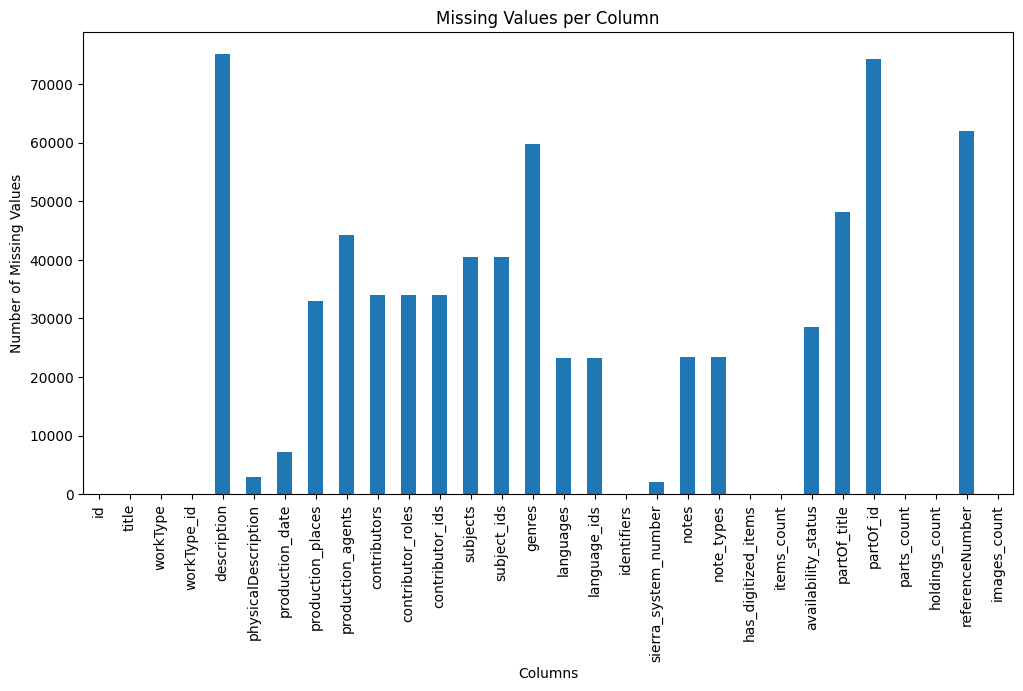


A random record from the dataframe:



,20007
id,m5k6vhfh
title,"History of Science Seminar, Cambridge, programmes and correspondence"
workType,Archives and manuscripts
workType_id,h
description,None
physicalDescription,1 File
production_date,1936-1939
production_places,None
production_agents,None
contributors,None


In [6]:
# shape of the dataset
print(f"\nOur filtered dataset has: {filtered.shape[1]} columns and {filtered.shape[0]} rows.")

# how many missing values per column
missing_values = filtered.isnull().sum()

plt.figure(figsize=(12,6))
plt.title("Missing Values per Column")
missing_values.plot(kind='bar')
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.show();

print_one_random_record(filtered)

We have now a dataframe more or less filtered but we still have a lot of columns that make no sense to use for our task, for example the _identifiers_. We will have to do some more __feature selection__.

In [7]:
# Remove non-predictable columns and with no corelation to the target
columns_to_remove = [
    # System IDs - just internal database identifiers, not predictable
    'id', 'workType_id', 'contributor_ids', 'subject_ids', 'language_ids', 
    'identifiers', 'sierra_system_number',
    
    # Counts - database metadata, not intrinsic properties of the work
    'items_count', 'parts_count', 'holdings_count', 'images_count',
    
    # Operational data - library-specific, not about the work itself
    'has_digitized_items', 'availability_status',
    
    # Less useful duplicates - keep the main version, remove auxiliary
    'note_types'  # Keep 'notes', remove the types since notes contain more info
]
necessary_df = filtered.copy().drop(columns=columns_to_remove);

# Display percentage of missing values per column with a custom styled table
null_pct = necessary_df.isnull().mean().sort_values(ascending=False) * 100
train_null = pd.DataFrame({
    "Column": null_pct.index,
    "% Null": [f"{v:.2f}%" for v in null_pct.values]
})

css = """
<style> 
.table-fixed {border-collapse: collapse; width: 70%; max-width: 900px;} 
.table-fixed th, 
.table-fixed td {border: 1px solid #ddd; padding: 6px 10px; text-align: left;} 
.table-fixed th {background:#808080; font-weight:600;} 
</style>
"""
print('We finally have only those columns left')
display(HTML(css + train_null.to_html(index=False, classes="table-fixed", escape=False)))

We finally have only those columns left


Column,% Null
description,75.11%
partOf_id,74.29%
referenceNumber,62.01%
genres,59.77%
partOf_title,48.26%
production_agents,44.21%
subjects,40.44%
contributors,34.00%
contributor_roles,34.00%
production_places,32.99%


In [11]:
print_one_random_record(necessary_df)


A random record from the dataframe:



,81011
title,"Shampoos : scientific basis and clinical aspects / edited by R.P.R. Dawber ; Proceedings of the Hair Care Forum sponsored by Proctor & Gamble (H&BC) Ltd., held in Florence, Italy on 28 October 1995."
workType,Books
description,None
physicalDescription,"x, 41 pages : colour illustrations ; 24 cm."
production_date,1996
production_places,London
production_agents,Royal Society of Medicine Press
contributors,Rodney Peter Richard Dawber; Royal Society of Medicine
contributor_roles,Unknown; Unknown
subjects,Hair Preparations; Cosmetics; Hair


__Our dataset only contains columns that interest us.__ 

# Preprocessing
We now have to __preprocess__ the data. The goal is to predict missing values in the dataset using the other fields as input so we will not have to fill NaNs. But we still have to deal with classic preprocessings such as categorical variables encoding, text vectorization and normalization.

We do not want to _infect_ our testing dataset with the training one. So we split them before any normalization.

In [12]:
train_test_ratio = 0.8
train = necessary_df.sample(frac = train_test_ratio, random_state= 42)
test = necessary_df.drop(train.index)
print(f"We decide to use {train_test_ratio*100}% of the data for the training.\n"
      f"Therefore we have a training sample of size {train.shape} and the test one of size {test.shape}")

We decide to use 80.0% of the data for the training.
Therefore we have a training sample of size (80000, 16) and the test one of size (20000, 16)


In [13]:
cumsum = train['production_places'].value_counts(normalize=True).cumsum()
print(f"We need the top {(cumsum <= 0.80).sum()} of the values to span 80% of all the production_places inside the dataset")
cumsum = train['languages'].value_counts(normalize=True).cumsum()
print(f"We need the top {(cumsum <= 0.95).sum()} of the values to span 95% of all the languages inside the dataset")
cumsum = train['workType'].value_counts(normalize=True).cumsum()
print(f"We need the top {(cumsum <= 0.95).sum()} of the values to span 95% of all the workType inside the dataset")


We need the top 535 of the values to span 80% of all the production_places inside the dataset
We need the top 17 of the values to span 95% of all the languages inside the dataset
We need the top 4 of the values to span 95% of all the workType inside the dataset


## Data Preprocessing Strategy

Our preprocessing pipeline is intentionally **minimal** - we leverage BERT's native ability to handle raw text and categorical data without explicit feature engineering.

### Target Variable

- **`production_date`**: Extract numeric year values from production_date strings via regex. This becomes our regression target.

### Minimal Preprocessing Rationale

Rather than traditional preprocessing (one-hot encoding, TF-IDF vectorization), we feed raw data directly to BERT for several reasons:

**Why not one-hot encode categorical features?**
- `workType` has only 16 unique values → trivial to one-hot encode
- But BERT embeddings capture semantic relationships better than binary vectors
- Example: "Book" and "Journal" are semantically closer than their one-hot representations suggest
- BERT learns distributed representations that preserve categorical meaning

**Why not TF-IDF for text?**
- TF-IDF treats words independently; BERT captures contextual relationships
- TF-IDF loses temporal signals (e.g., "1928" is just another term); BERT recognizes date expressions
- BERT handles variable-length sequences naturally without dimensionality reduction

**Direct comparison:** We compare TF-IDF + simple regressors against BERT embeddings + simple regressors to quantify improvement.

### Preprocessing Pipeline

1. **Merge Text Features**: Concatenate all text columns (title, description, notes, physicalDescription, partOf_title, production_places, production_agents, subjects, genres, languages, workType, contributors) into single text string with field separators

2. **Format for BERT**: Create input with structure:
```
   [TITLE: {title}] [DESC: {description}] [TYPE: {workType}] [LANG: {languages}] [SUBJ: {subjects}] ...
```
   Field labels help BERT distinguish information types

3. **Target Extraction**: Parse `production_date` → extract year as integer and not string

4. **Final Dataset**: Two columns:
   - `text`: Merged BERT input string
   - `year`: Target variable (numeric)

### Why This Works

BERT's transformer architecture:
- Handles variable text lengths without dimensionality reduction
- Learns categorical embeddings automatically through token representation
- Captures semantic relationships (e.g., "published 1950" → temporal context)
- No manual feature engineering needed

Result: Cleaner pipeline, better feature representations, comparison baseline (TF-IDF) included.

In [14]:
for col in train.columns:
    types = train[col].apply(lambda x: type(x).__name__).unique()
    print(col, "->", types)

title -> ['str']
workType -> ['str']
description -> ['NoneType' 'str']
physicalDescription -> ['str' 'NoneType']
production_date -> ['str' 'NoneType']
production_places -> ['str' 'NoneType']
production_agents -> ['str' 'NoneType']
contributors -> ['str' 'NoneType']
contributor_roles -> ['str' 'NoneType']
subjects -> ['str' 'NoneType']
genres -> ['str' 'NoneType']
languages -> ['str' 'NoneType']
notes -> ['str' 'NoneType']
partOf_title -> ['str' 'NoneType']
partOf_id -> ['NoneType' 'str']
referenceNumber -> ['str' 'NoneType']


We merge all the column of the dataframe to simplify the format for BERT embeding. Only `thumbnail_url` and `production_date` are kept as they already are.

In [16]:
# We keep production_date in a separate column and the thumbnail URL too
columns_to_merge = [c for c in train.columns 
                    if c not in ["production_date", "thumbnail_url"]]

df_for_merge = train[columns_to_merge].copy()

def format_row(row):
    parts = []
    for col in row.index:
        col_upper = col.upper()
        value = row[col]

        if pd.isna(value):
            value = ""

        parts.append(f"[{col_upper}: {{{value}}}]")

    return " ".join(parts)

# Create MERGED in a separate dataframe
merged_train = pd.DataFrame()
merged_train["MERGED"] = df_for_merge.apply(format_row, axis=1)

# Add the two separated columns (from train)
merged_train["production_date"] = pd.to_numeric(
    train["production_date"], errors="coerce"
)

merged_train = merged_train.reset_index(drop = True)
print_one_random_record(merged_train)


A random record from the dataframe:



,9533
MERGED,[TITLE: {Meetings between CUP and The Physiological Society: minutes and agendas}] [WORKTYPE: {Archives and manuscripts}] [DESCRIPTION: {}] [PHYSICALDESCRIPTION: {4 files}] [PRODUCTION_PLACES: {}] [PRODUCTION_AGENTS: {}] [CONTRIBUTORS: {}] [CONTRIBUTOR_ROLES: {}] [SUBJECTS: {}] [GENRES: {}] [LANGUAGES: {English}] [NOTES: {}] [PARTOF_TITLE: {The Society's journals and the relationship with publisher}] [PARTOF_ID: {j29erffx}] [REFERENCENUMBER: {SA/PHY/F/8/1}]
production_date,NaN


## BERT

SyntaxError: expected argument value expression (2393581428.py, line 17)